# Project: Wrangling and Analyze Data

# Table of Contents

* [Data Gathering](#gather)
* [Assessing Data](#assess)
* [Cleaning Data](#cleaning)<br>
    * [Quality Issues](#quality) <br>
        * [Issue #1: Timestamp is an object not a date](#1)<br>
        * [Issue #2: Retweeted_status_timestamp is an object not a date](#2)<br>
        * [Issue #3: Incorrect Rating Denominator](#3)<br>
        * [Issue #4: Incorrect dogs' names](#4)<br>
        * [Issue #5: None instead of Nan for dogs' stage columns](#5)<br>
        * [Issue #6: Inconsistent column names](#6)<br>
        * [Issue #7: No meaningful names in prediction table](#7)<br>
        * [Issue #8: Inconsistent size of letters in predictions](#8)<br>
        * [Issue #9: Remove retweets](#9)<br>
    * [Tidiness Issues](#tidy)<br>
        * [Issue #1: Dog stage in four columns](#dogstage)<br>
        * [Issue #2: Twitter API details and Twitter data should be in one table](#mergetables)<br>
        * [Issue #3: Remove empty columns](#col)<br>
* [Insights and Visualizations](#vis)
      
      
      

            
        

## Data Gathering
1. Directly download the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)
<a id = "gather"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline



twitter_archive_data = pd.read_csv('twitter-archive-enhanced.csv')

twitter_archive_data.head()


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


2. Use the Requests library to download the tweet image prediction (image_predictions.tsv)

In [2]:
import requests
import os

folder_name = 'img_predictions'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)



url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)

response.status_code

200

In [3]:
with open(os.path.join(folder_name, url.split('/')[-1]), mode = 'wb') as file:
    file.write(response.content)

In [4]:
img_prediction = pd.read_csv('img_predictions/image-predictions.tsv', '\t')

img_prediction.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [ ]:
import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer

# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# These are hidden to comply with Twitter's API terms and conditions
consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

# NOTE TO STUDENT WITH MOBILE VERIFICATION ISSUES:
# df_1 is a DataFrame with the twitter_archive_enhanced.csv file. You may have to
# change line 17 to match the name of your DataFrame with twitter_archive_enhanced.csv
# NOTE TO REVIEWER: this student had mobile verification issues so the following
# Twitter API code was sent to this student from a Udacity instructor
# Tweet IDs for which to gather additional data via Twitter's API
tweet_ids = twitter_archive_data.tweet_id.values
len(tweet_ids)

# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)

3. Use the Tweepy library to query additional data via the Twitter API (tweet_json.txt)

In [5]:
import json

data = []

with open ('tweet-json.txt') as file:
    for line in file:
        data.append(json.loads(line))
        
        
       
df_tweeter_api = pd.DataFrame(data)
df_tweeter_api.head()
df_tweeter_api.columns

Index(['contributors', 'coordinates', 'created_at', 'display_text_range',
       'entities', 'extended_entities', 'favorite_count', 'favorited',
       'full_text', 'geo', 'id', 'id_str', 'in_reply_to_screen_name',
       'in_reply_to_status_id', 'in_reply_to_status_id_str',
       'in_reply_to_user_id', 'in_reply_to_user_id_str', 'is_quote_status',
       'lang', 'place', 'possibly_sensitive', 'possibly_sensitive_appealable',
       'quoted_status', 'quoted_status_id', 'quoted_status_id_str',
       'retweet_count', 'retweeted', 'retweeted_status', 'source', 'truncated',
       'user'],
      dtype='object')

In [6]:
df_tweeter_api = df_tweeter_api[['id', 'retweet_count', 'favorite_count']]
df_tweeter_api.head()

,id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048


## Assessing Data
In this section, detect and document at least **eight (8) quality issues and two (2) tidiness issue**. You must use **both** visual assessment
programmatic assessement to assess the data.

**Note:** pay attention to the following key points when you access the data.

* You only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.
* Assessing and cleaning the entire dataset completely would require a lot of time, and is not necessary to practice and demonstrate your skills in data wrangling. Therefore, the requirements of this project are only to assess and clean at least 8 quality issues and at least 2 tidiness issues in this dataset.
* The fact that the rating numerators are greater than the denominators does not need to be cleaned. This [unique rating system](http://knowyourmeme.com/memes/theyre-good-dogs-brent) is a big part of the popularity of WeRateDogs.
* You do not need to gather the tweets beyond August 1st, 2017. You can, but note that you won't be able to gather the image predictions for these tweets since you don't have access to the algorithm used.

<a id = "assess"></a>

### Quality issues
1. Twitter Archive Data: Timestamp is an object not a date

2. Twitter Archive Data: Retweeted Status Timestamp is an object not a date

3. Twitter Archive Data: Incorrect Rating Denominator

4. Twitter Archive Data: Incorrect dogs' names

5. Twitter Archive Data: None instead of Nan for dogs' breed columns

6. Twitter API: Inconsistent column names

7. IMG Predictions: No meaningful names in prediction table

8. IMG Predictions: Inconsistent size of letters in predictions

9. Twitter Archive Data: Retweets included in data set

### Tidiness issues
1. Twitter Archive Data: Dog breed in four columns

2. Twitter API and Twitter Archive Data should be in one table

In [20]:
twitter_archive_data

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [21]:
twitter_archive_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [22]:
# check denominator values
twitter_archive_data.rating_denominator.value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [23]:
# check duplicates
twitter_archive_data[twitter_archive_data.duplicated(['tweet_id']) == True].tweet_id

Series([], Name: tweet_id, dtype: int64)

In [24]:
img_prediction

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


In [25]:
img_prediction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [16]:
df_tweeter_api

,id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048
5,891087950875897856,3261,20562
6,890971913173991426,2158,12041
7,890729181411237888,16716,56848
8,890609185150312448,4429,28226
9,890240255349198849,7711,32467


In [26]:
df_tweeter_api.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
id                2354 non-null int64
retweet_count     2354 non-null int64
favorite_count    2354 non-null int64
dtypes: int64(3)
memory usage: 55.2 KB


In [27]:
df_tweeter_api.describe()

,id,retweet_count,favorite_count
count,2.354000e+03,2354.000000,2354.000000
mean,7.426978e+17,3164.797366,8080.968564
std,6.852812e+16,5284.770364,11814.771334
min,6.660209e+17,0.000000,0.000000
25%,6.783975e+17,624.500000,1415.000000
50%,7.194596e+17,1473.500000,3603.500000
75%,7.993058e+17,3652.000000,10122.250000
max,8.924206e+17,79515.000000,132810.000000


## Cleaning Data
In this section, clean **all** of the issues you documented while assessing. 

**Note:** Make a copy of the original data before cleaning. Cleaning includes merging individual pieces of data according to the rules of [tidy data](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html). The result should be a high-quality and tidy master pandas DataFrame (or DataFrames, if appropriate).

<a id = "cleaning"></a>

In [59]:
# Make copies of original pieces of data
twitter_archive_data_clean = twitter_archive_data.copy()
img_prediction_clean = img_prediction.copy()
df_tweeter_api_clean = df_tweeter_api.copy()

### Quality Issues
<a id = "quality"></a>

### Issue #1: Timestamp is an object not a date
<a id = "1"></a>

#### Define
Convert a timestamp to a datetime

#### Code

In [60]:
twitter_archive_data_clean.timestamp = pd.to_datetime(twitter_archive_data_clean.timestamp)

#### Test

In [61]:
twitter_archive_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null datetime64[ns]
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: datetime64[ns](1

### Issue #2: Retweeted_status_timestamp is an object not a date
<a id = "2"></a>

#### Define
Retweeted_status_timestamp is an object not a datetime

#### Code

In [62]:
twitter_archive_data_clean.retweeted_status_timestamp = pd.to_datetime(twitter_archive_data_clean.retweeted_status_timestamp)

#### Test

In [63]:
twitter_archive_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null datetime64[ns]
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null datetime64[ns]
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: datetime

### Issue #3: Incorrect Rating Denominator
<a id = "3"></a>

#### Define 
For same cases rating denominator is greater than 10. As per definition it shold always be equal to 10. Remove incorrect rows.

#### Code

In [64]:
twitter_archive_data_clean.rating_denominator.value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [65]:
twitter_archive_data_clean = twitter_archive_data_clean[twitter_archive_data_clean['rating_denominator'] == 10]

#### Test

In [66]:
twitter_archive_data_clean.rating_denominator.value_counts()

10    2333
Name: rating_denominator, dtype: int64

### Issue #4: Incorrect dogs' names
<a id = "4"></a>

#### Define
Remove rows with incorrect dogs' names. <br>
For some cases there are incorrect dogs' names such as: a , the, such instead of real dog name. 

#### Code

In [67]:
twitter_archive_data_clean['name_check'] = twitter_archive_data_clean.name.str.istitle()
twitter_archive_data_clean.head()

twitter_archive_data_clean = twitter_archive_data_clean[twitter_archive_data_clean['name_check'] == True]

#### Test

In [68]:
twitter_archive_data_clean.shape
twitter_archive_data_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,name_check
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None,True
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaT,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None,True
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None,True
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None,True
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None,True


In [69]:
twitter_archive_data_clean.name.value_counts()

None         728
Charlie       12
Oliver        11
Cooper        11
Lucy          11
Penny         10
Tucker        10
Lola          10
Bo             9
Winston        9
Sadie          8
Buddy          7
Bailey         7
Toby           7
Daisy          7
Dave           6
Oscar          6
Stanley        6
Jax            6
Scout          6
Rusty          6
Leo            6
Milo           6
Koda           6
Jack           6
Bella          6
Oakley         5
George         5
Phil           5
Gus            5
            ... 
Claude         1
Bobbay         1
Corey          1
Freddery       1
Kloey          1
Swagger        1
Zuzu           1
Sobe           1
Furzey         1
Pawnd          1
Hamrick        1
Mark           1
Emma           1
Joey           1
Andru          1
Chuq           1
Tess           1
Mya            1
Dobby          1
Tupawc         1
Richie         1
Scruffers      1
Monster        1
Laika          1
Striker        1
Scott          1
Mack           1
Mason         

In [70]:
twitter_archive_data_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,name_check
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None,True
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaT,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None,True
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None,True
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None,True
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None,True


### Issue #5: None instead of Nan for dogs' stage columns
<a id = "5"></a>

#### Define
Replace string 'None' with Nan for doggo, floofer, pupper, puppo columns

#### Code

In [71]:
twitter_archive_data_clean = twitter_archive_data_clean.replace('None', np.nan)

#### Test

In [72]:
twitter_archive_data_clean.doggo.value_counts()

doggo    93
Name: doggo, dtype: int64

In [73]:
twitter_archive_data_clean.floofer.value_counts()

floofer    10
Name: floofer, dtype: int64

In [74]:
twitter_archive_data_clean.pupper.value_counts()

pupper    243
Name: pupper, dtype: int64

In [75]:
twitter_archive_data_clean.puppo.value_counts()

puppo    30
Name: puppo, dtype: int64

### Issue #6: Inconsistent column names
<a id = "6"></a>

#### Define 
Rename column id in twitter_api to have a consistency with the same column in twitter_data

#### Code 

In [76]:
df_tweeter_api_clean = df_tweeter_api_clean.rename(columns = {"id": "tweet_id"})

#### Test

In [77]:
df_tweeter_api_clean.head()

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048


### Issue #7: No meaningful names in prediction table
<a id = "7"></a>

#### Define
Instead of using p1, p2, p3 use prediction1, prediction2, prediction3.
With current names it is difficult to understand what this abbreviation stands for

#### Code

In [78]:
img_prediction_clean = img_prediction_clean.rename(columns = {"p1": "prediction_1", "p1_conf": "prediction_1_conf", "p1_dog": "prediction_1_dog",
                                                             "p2": "prediction_2", "p2_conf": "prediction_2_conf", "p2_dog": "prediction_2_dog",
                                                             "p3": "prediction_3", "p3_conf": "prediction_3_conf", "p3_dog": "prediction_3_dog"})

#### Test

In [79]:
img_prediction_clean.head()

,tweet_id,jpg_url,img_num,prediction_1,prediction_1_conf,prediction_1_dog,prediction_2,prediction_2_conf,prediction_2_dog,prediction_3,prediction_3_conf,prediction_3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


### Issue #8: Inconsistent size of letters in predictions
<a id = "8"></a>

#### Define
Some dog names start with lower case some with uppercase. Use one pattern for all. Change it all to lowercase.

#### Code

In [80]:
img_prediction_clean['prediction_1'] = img_prediction_clean['prediction_1'].str.lower()
img_prediction_clean['prediction_2'] = img_prediction_clean['prediction_2'].str.lower()
img_prediction_clean['prediction_3'] = img_prediction_clean['prediction_3'].str.lower()

#### Test

In [81]:
img_prediction_clean.head()

,tweet_id,jpg_url,img_num,prediction_1,prediction_1_conf,prediction_1_dog,prediction_2,prediction_2_conf,prediction_2_dog,prediction_3,prediction_3_conf,prediction_3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,welsh_springer_spaniel,0.465074,True,collie,0.156665,True,shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,german_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,rottweiler,0.243682,True,doberman,0.154629,True


### Issue #9: Remove retweets 
<a id = "9"></a>

#### Define
For purpose of analysis we need only orignal rates. Retweets not needed. Remove rows with retweets.

#### Code

In [82]:
twitter_archive_data_clean = twitter_archive_data_clean[twitter_archive_data_clean.retweeted_status_id.isnull()]
twitter_archive_data_clean = twitter_archive_data_clean[twitter_archive_data_clean.retweeted_status_user_id.isnull()]
twitter_archive_data_clean = twitter_archive_data_clean[twitter_archive_data_clean.retweeted_status_timestamp.isnull()]

#### Test

In [83]:
twitter_archive_data_clean.retweeted_status_id.value_counts()

Series([], Name: retweeted_status_id, dtype: int64)

In [84]:
twitter_archive_data_clean.retweeted_status_user_id.value_counts()

Series([], Name: retweeted_status_user_id, dtype: int64)

In [85]:
twitter_archive_data_clean.retweeted_status_timestamp.value_counts()

Series([], Name: retweeted_status_timestamp, dtype: int64)

In [86]:
twitter_archive_data_clean.shape

(2046, 18)

### Tidiness issues
<a id = "tidy"></a>

### Issue #1: Dog stage in four columns
<a id = "dogstage"></a>

#### Define
Merge the doggo, floofer, pupper, puppo columns into a breed column

#### Code

In [90]:
dogs_stage = pd.melt(twitter_archive_data_clean, id_vars=['tweet_id'], value_vars=['doggo', 'floofer', 'pupper', 'puppo'],
        value_name='dog_stage')

dogs_stage = dogs_stage[dogs_stage['dog_stage'].notnull()]
dogs_stage = dogs_stage.iloc[:, [0,2]]


#merge data frames
twitter_archive_data_clean = pd.merge(twitter_archive_data_clean, dogs_stage, how = 'left', on = 'tweet_id')
twitter_archive_data_clean.head()

#remove unneccesary columns
twitter_archive_data_clean.drop(columns=['doggo', 'floofer', 'pupper', 'puppo', 'name_check'], inplace = True)

#### Test

In [115]:
twitter_archive_data_clean.dog_stage.value_counts()

pupper     222
doggo       84
puppo       25
floofer     10
Name: dog_stage, dtype: int64

In [45]:
twitter_archive_data_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,breed
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,NaN
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaT,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,NaN
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,NaN
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,NaN
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,NaN


### Issue #2: Twitter API details and Twitter data should be in one table
<a id = "mergetables"></a>

#### Define
Each type of observational unit should form a table. Twitter archive data and additional Twitter data should be merged into one table

#### Code

In [93]:
twitter_archive_data_api_clean = pd.merge(twitter_archive_data_clean, df_tweeter_api_clean, how = 'left', on='tweet_id')

#### Test

In [94]:
twitter_archive_data_api_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,retweet_count,favorite_count
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,NaN,8853,39467
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaT,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,NaN,6514,33819
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,NaN,4328,25461
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,NaN,8964,42908
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,NaN,9774,41048


### Issue #3: Unnecessary columns
<a id = "col"></a>

#### Define
After removing retweets all three columns: retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp can be removed.

#### Code

In [116]:
twitter_archive_data_api_clean.drop(columns=['retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp'], inplace = True)

#### Test

In [117]:
twitter_archive_data_api_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2057 entries, 0 to 2056
Data columns (total 13 columns):
tweet_id                 2057 non-null int64
in_reply_to_status_id    74 non-null float64
in_reply_to_user_id      74 non-null float64
timestamp                2057 non-null datetime64[ns]
source                   2057 non-null object
text                     2057 non-null object
expanded_urls            2003 non-null object
rating_numerator         2057 non-null int64
rating_denominator       2057 non-null int64
name                     1386 non-null object
dog_stage                341 non-null object
retweet_count            2057 non-null int64
favorite_count           2057 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(5), object(5)
memory usage: 225.0+ KB


## Storing Data
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [118]:
twitter_archive_master = pd.merge(twitter_archive_data_api_clean, img_prediction_clean, how = 'left', on = 'tweet_id')

twitter_archive_master.to_csv('twitter_archive_master.csv', index = False)

## Analyzing and Visualizing Data
In this section, analyze and visualize your wrangled data. You must produce at least **three (3) insights and one (1) visualization.**
<a id = "vis"></a>

In [119]:
df = pd.read_csv('twitter_archive_master.csv')

In [120]:
df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,...,img_num,prediction_1,prediction_1_conf,prediction_1_dog,prediction_2,prediction_2_conf,prediction_2_dog,prediction_3,prediction_3_conf,prediction_3_dog
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,...,1.0,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,...,1.0,chihuahua,0.323581,True,pekinese,0.090647,True,papillon,0.068957,True
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,...,1.0,chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,...,1.0,paper_towel,0.170278,False,labrador_retriever,0.168086,True,spatula,0.040836,False
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,...,2.0,basset,0.555712,True,english_springer,0.225770,True,german_short-haired_pointer,0.175219,True


In [121]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2057 entries, 0 to 2056
Data columns (total 24 columns):
tweet_id                 2057 non-null int64
in_reply_to_status_id    74 non-null float64
in_reply_to_user_id      74 non-null float64
timestamp                2057 non-null object
source                   2057 non-null object
text                     2057 non-null object
expanded_urls            2003 non-null object
rating_numerator         2057 non-null int64
rating_denominator       2057 non-null int64
name                     1386 non-null object
dog_stage                341 non-null object
retweet_count            2057 non-null int64
favorite_count           2057 non-null int64
jpg_url                  1885 non-null object
img_num                  1885 non-null float64
prediction_1             1885 non-null object
prediction_1_conf        1885 non-null float64
prediction_1_dog         1885 non-null object
prediction_2             1885 non-null object
prediction_2_conf        

In [122]:
df.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,rating_numerator,rating_denominator,retweet_count,favorite_count,img_num,prediction_1_conf,prediction_2_conf,prediction_3_conf
count,2.057000e+03,7.400000e+01,7.400000e+01,2057.000000,2057.0,2057.000000,2057.000000,1885.000000,1885.000000,1.885000e+03,1.885000e+03
mean,7.392540e+17,7.454371e+17,2.123045e+16,12.367526,10.0,2809.660185,8958.402528,1.206366,0.595944,1.340139e-01,5.984668e-02
std,6.791772e+16,7.549679e+16,1.285751e+17,43.657727,0.0,4708.941554,12163.435818,0.563732,0.272935,1.006822e-01,5.084999e-02
min,6.660209e+17,6.658147e+17,1.185634e+07,0.000000,10.0,0.000000,52.000000,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.776984e+17,6.755497e+17,3.859888e+08,10.000000,10.0,624.000000,2044.000000,1.000000,0.360428,5.353130e-02,1.543210e-02
50%,7.120974e+17,7.062329e+17,4.196984e+09,11.000000,10.0,1378.000000,4188.000000,1.000000,0.589066,1.170030e-01,4.891980e-02
75%,7.931808e+17,8.227829e+17,4.196984e+09,12.000000,10.0,3261.000000,11411.000000,1.000000,0.853170,1.948670e-01,9.214290e-02
max,8.924206e+17,8.862664e+17,8.405479e+17,1776.000000,10.0,79515.000000,132810.000000,4.000000,1.000000,4.880140e-01,2.710420e-01


In [123]:
df.name.value_counts()

Lucy            11
Charlie         11
Cooper          10
Oliver          10
Penny            9
Tucker           9
Sadie            8
Lola             8
Winston          8
Toby             7
Daisy            7
Oscar            6
Bella            6
Stanley          6
Bo               6
Koda             6
Bailey           6
Jax              6
Milo             5
Bentley          5
Chester          5
Louis            5
Maggie           5
Scout            5
Buddy            5
Dave             5
Rusty            5
Leo              5
Archie           4
Jeffrey          4
                ..
Geno             1
Burt             1
Blakely          1
Sandra           1
Chloe            1
Scruffers        1
Richie           1
Tupawc           1
Travis           1
Snicku           1
Canela           1
Evy              1
Jonah            1
Wesley           1
Skittles         1
Tuck             1
Boots            1
Beemo            1
Al               1
Dobby            1
Cleopatricia     1
Hamrick     

In [124]:
df.groupby('dog_stage').agg({"rating_numerator": "mean"}).reset_index()

,dog_stage,rating_numerator
0,doggo,11.761905
1,floofer,11.800000
2,pupper,10.788288
3,puppo,12.080000


### Insights:
1. The highest note for a dog is 1776. But 75% observations have a rating not grater than 12

2. Lucy and Charlie are most common dog name

3. Puppo has the higest average rating

### Visualization

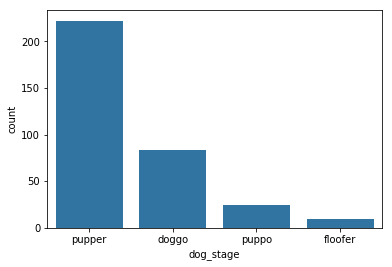

In [125]:
import seaborn as sb

freq = df['dog_stage'].value_counts()
gen_order = freq.index
base_color = sb.color_palette()[0]
sb.countplot(data=df, x='dog_stage', color = base_color, order = gen_order);


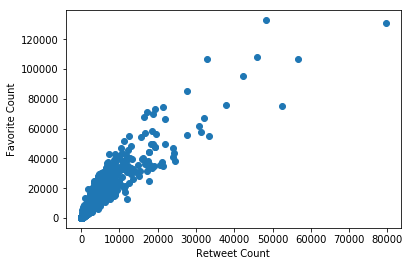

In [126]:
plt.scatter(data = df, x = 'retweet_count', y ='favorite_count')
plt.xlabel('Retweet Count')
plt.ylabel('Favorite Count');

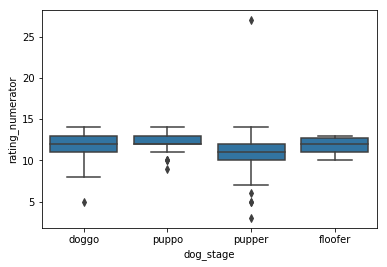

In [127]:
sb.boxplot(data=df, x='dog_stage', y='rating_numerator', color=base_color);